In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
from matplotlib import rc

In [31]:
data = pd.read_csv('/Users/shreysharma/Downloads/showwcase_sessions.csv')

In [261]:
data

,session_id,customer_id,login_date,projects_added,likes_given,comment_given,inactive_status,bug_occured,session_projects_added,session_likes_given,session_comments_given,inactive_duration,bugs_in_session,session_duration
0,624205.0,80746.0,10/30/19,False,True,True,True,False,0.0,24.0,3.0,1146.0,0.0,1564.0
1,624241.0,24520.0,10/30/19,True,True,True,True,False,2.0,3.0,5.0,133.0,0.0,1766.0
2,111002.0,32047.0,10/30/19,True,True,True,True,False,1.0,5.0,5.0,1571.0,0.0,2230.0
3,545113.0,23404.0,10/30/19,True,True,True,False,False,1.0,10.0,21.0,0.0,0.0,633.0
4,750269.0,40235.0,10/30/19,True,True,False,True,False,3.0,16.0,0.0,1405.0,0.0,1679.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,643880.0,51243.0,10/1/19,True,False,False,True,False,2.0,0.0,0.0,906.0,0.0,1990.0
298,844518.0,23083.0,10/1/19,True,False,False,True,False,1.0,0.0,0.0,139.0,0.0,1113.0
299,933954.0,38459.0,10/1/19,True,False,False,False,False,1.0,0.0,0.0,0.0,0.0,306.0
300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#converting boolean to int
data[['projects_added','likes_given','comment_given','inactive_status','bug_occured']]=data[['projects_added','likes_given','comment_given','inactive_status','bug_occured']].astype('bool')
data[['projects_added','likes_given','comment_given','inactive_status','bug_occured']]=data[['projects_added','likes_given','comment_given','inactive_status','bug_occured']].astype('int')

In [33]:
#converting to date type
data['login_date'] = pd.to_datetime(data['login_date'])

In [86]:
df = data[['login_date','inactive_duration','session_duration']]
df.head()

,login_date,inactive_duration,session_duration
0,2019-10-30,1146.0,1564.0
1,2019-10-30,133.0,1766.0
2,2019-10-30,1571.0,2230.0
3,2019-10-30,0.0,633.0
4,2019-10-30,1405.0,1679.0


In [87]:
df = df.groupby(['login_date'])[['inactive_duration','session_duration']].mean()

In [88]:
df.head()

,inactive_duration,session_duration
login_date,,
2019-10-01,587.888889,1383.333333
2019-10-02,1050.200000,1075.000000
2019-10-03,712.700000,1264.500000
2019-10-04,768.222222,1139.000000
2019-10-05,152.000000,1114.857143


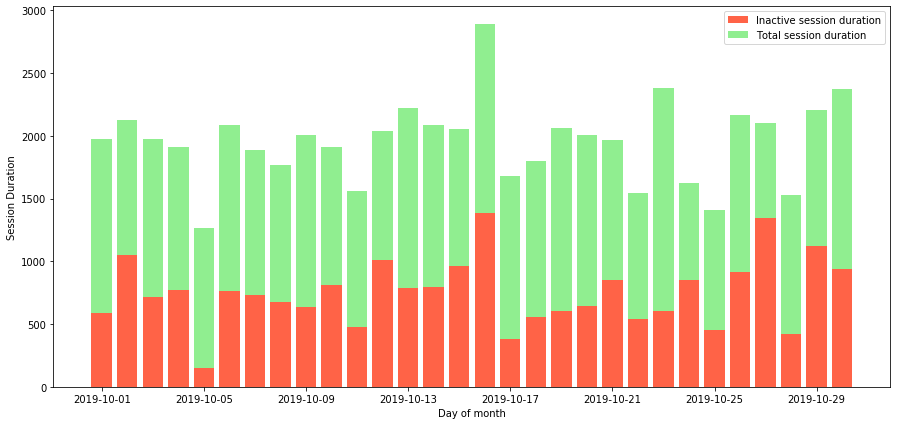

In [91]:
plt.figure(figsize=(15,7))
p1 = plt.bar(df.index, df.inactive_duration,label='Inactive session duration',color='tomato')
p2 = plt.bar(df.index, df.session_duration, bottom=df.inactive_duration, label='Total session duration',color='lightgreen')
plt.xlabel('Day of month')
plt.ylabel('Session Duration')
plt.legend(loc='best')

In [159]:
c1 = data[['session_id','inactive_status','bug_occured']]
c1.head()

,session_id,inactive_status,bug_occured
0,624205.0,1,0
1,624241.0,1,0
2,111002.0,1,0
3,545113.0,0,0
4,750269.0,1,0


In [34]:
customer = data[['customer_id','session_duration','session_projects_added',
                 'session_comments_given','session_likes_given',
                'bugs_in_session']]

inactiveness might be related to the bug occured in a session

In [35]:
customer = customer.groupby(['customer_id'])[['session_duration','session_projects_added','session_comments_given'
                                              ,'session_likes_given','bugs_in_session']].sum()

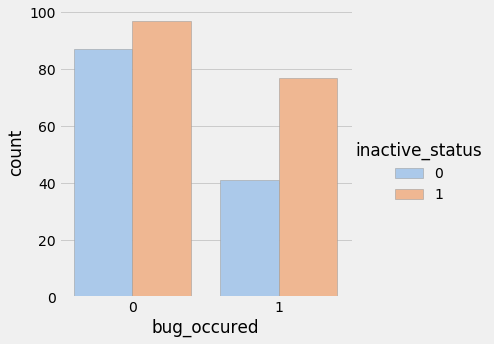

In [161]:
sns.catplot(x="bug_occured", hue="inactive_status", kind="count",
            palette="pastel", edgecolor=".6",
            data=c1)

###  More projects doesn't necessarily means more likes

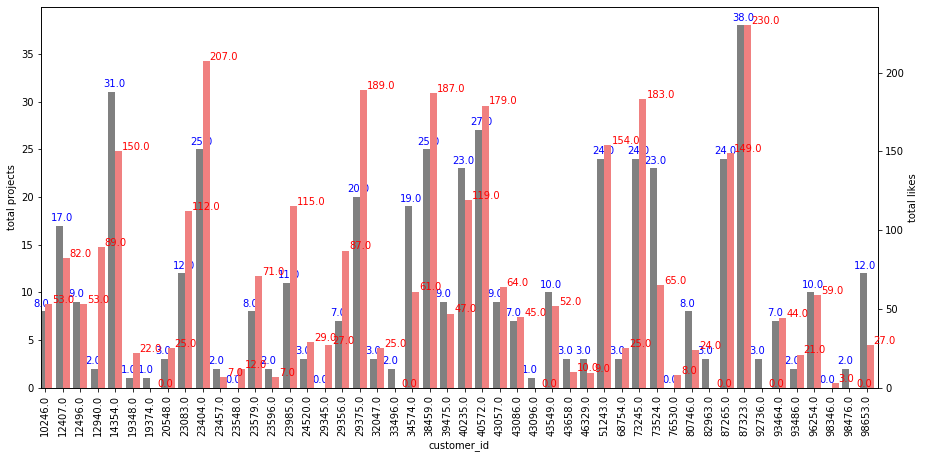

In [44]:
fig= plt.figure(figsize=(15,7))
ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

width = 0.4

customer.session_projects_added.plot(kind='bar',color='grey', ax=ax, width=width, position=1)
customer.session_likes_given.plot(kind='bar', color='lightcoral',ax=ax2, width=width, position=0)

for i, v in enumerate(customer.session_projects_added):
    ax.text(i-0.7 , v+0.5 , str(v), color='blue')
    
for i, v in enumerate(customer.session_likes_given):
    ax2.text(i+0.4 , v+0.75 , str(v), color='red')

ax.set_ylabel('total projects')
ax2.set_ylabel('total likes')
plt.show()

### Clustering

In [44]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(customer[['session_projects_added', 'session_likes_given', 'session_comments_given']])
customer['Cluster'] = y

## Lifetime value (LTV)

In [45]:
customer[customer.Cluster==0].describe()

,session_duration,session_projects_added,session_comments_given,session_likes_given,bugs_in_session,Cluster
count,9.000000,9.000000,9.000000,9.000000,9.00000,9.0
mean,19736.333333,26.444444,41.222222,180.888889,21.00000,0.0
std,5343.237315,5.222813,10.544878,27.154394,7.17635,0.0
min,12556.000000,20.000000,26.000000,149.000000,12.00000,0.0
25%,17375.000000,24.000000,36.000000,154.000000,15.00000,0.0
50%,17773.000000,25.000000,41.000000,183.000000,24.00000,0.0
75%,22880.000000,27.000000,44.000000,189.000000,25.00000,0.0
max,30356.000000,38.000000,64.000000,230.000000,33.00000,0.0


In [46]:
customer[customer.Cluster==1].describe()

,session_duration,session_projects_added,session_comments_given,session_likes_given,bugs_in_session,Cluster
count,24.00000,24.000000,24.000000,24.000000,24.000000,24.0
mean,2134.75000,2.958333,3.958333,15.416667,1.708333,1.0
std,2160.02418,2.881412,4.638958,13.874959,2.561914,0.0
min,103.00000,0.000000,0.000000,0.000000,0.000000,1.0
25%,776.50000,1.000000,0.000000,2.250000,0.000000,1.0
50%,1313.00000,2.500000,2.500000,11.000000,0.000000,1.0
75%,2061.00000,3.000000,5.000000,25.000000,4.250000,1.0
max,7287.00000,12.000000,15.000000,45.000000,8.000000,1.0


In [47]:
customer[customer.Cluster==2].describe()

,session_duration,session_projects_added,session_comments_given,session_likes_given,bugs_in_session,Cluster
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.0
mean,8477.866667,11.800000,17.066667,75.266667,9.333333,2.0
std,4568.229586,6.026134,7.648218,24.294228,4.418576,0.0
min,2863.000000,2.000000,3.000000,47.000000,3.000000,2.0
25%,5998.500000,8.500000,13.000000,56.000000,6.500000,2.0
50%,6423.000000,10.000000,16.000000,65.000000,9.000000,2.0
75%,10339.500000,14.500000,22.500000,88.000000,11.000000,2.0
max,21117.000000,23.000000,34.000000,119.000000,19.000000,2.0


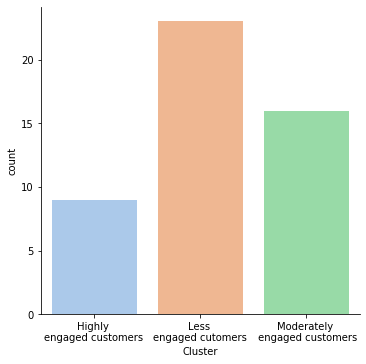

In [241]:
g=sns.catplot(x="Cluster", kind="count",data=customer, palette='pastel')
g.set_xticklabels(['Highly \nengaged customers','Less \nengaged cutomers','Moderately \n engaged customers'])

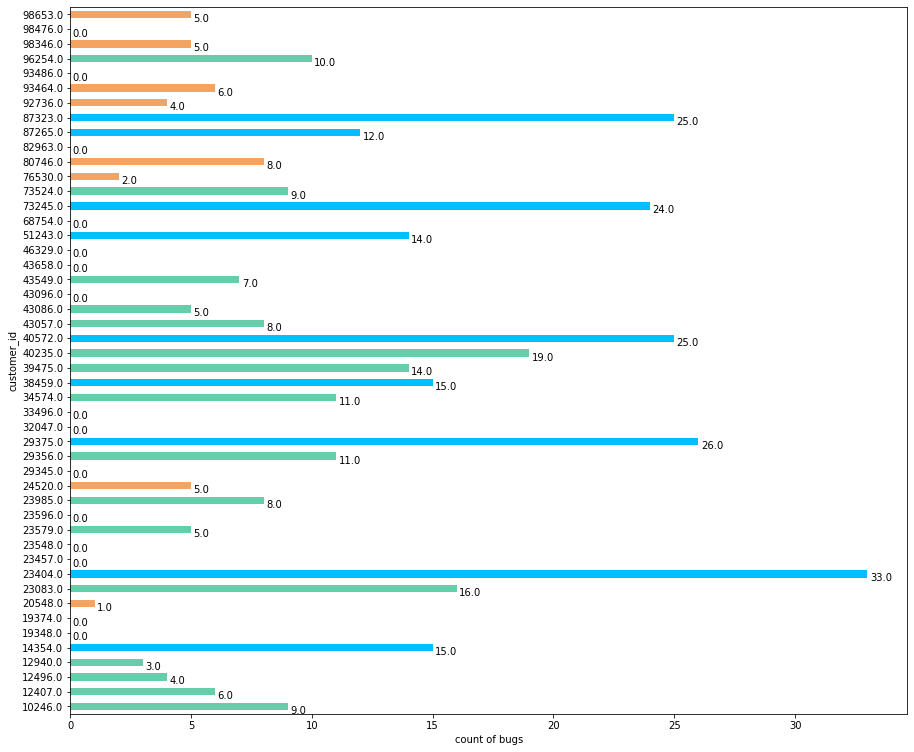

In [242]:
plt.figure(figsize=(15,13))

LABEL_COLOR_MAP = {0 : 'deepskyblue',
                   1 : 'sandybrown',
                   2 : 'mediumaquamarine' }

label_color = [LABEL_COLOR_MAP[l] for l in customer.Cluster]
customer.bugs_in_session.plot(kind='barh',color=label_color)
plt.xlabel('count of bugs')

for i, v in enumerate(customer.bugs_in_session):
    plt.text(v+0.1 , i-0.5 , str(v), color='black')

plt.show()

## Cohort Analysis

In [48]:
c2 = data[['customer_id','login_date','session_duration','session_projects_added',
                 'session_comments_given','session_likes_given']].dropna()

In [49]:
c2['week']=c2.login_date.dt.week

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [50]:
c2 = c2.groupby(['week','customer_id'])[['session_projects_added', 'session_likes_given', 'session_comments_given']].sum()

In [51]:
c=[]
for i in range(len(c2)):
    for j in range(len(customer)):
        if c2.index.get_level_values('customer_id')[i] == customer.index.values[j]:
             c.append(customer.Cluster.values[j])
c2['cluster']=c

## Most engaged users

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be re

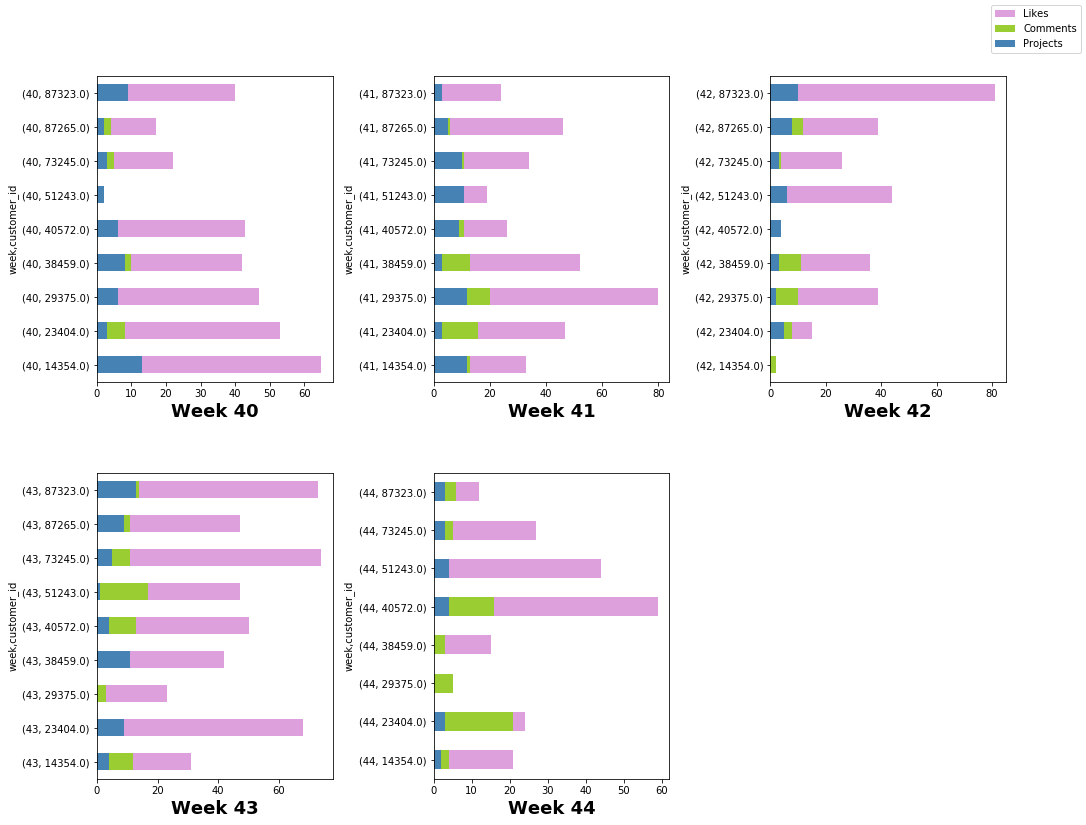

In [85]:
fig=plt.figure(figsize=(15,12))
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)

ax=[ax0,ax1,ax2,ax3,ax4]
fig.tight_layout(pad=7.0)

labels=['Week 40','Week 41','Week 42','Week 43','Week 44']

i=0
for j in range(40,45):
        
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==0]['session_likes_given'].plot(kind='barh',ax=ax[i],color='plum')
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==0]['session_comments_given'].plot(kind='barh',ax=ax[i],color='yellowgreen')               
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==0]['session_projects_added'].plot(kind='barh',ax=ax[i],color='steelblue')
        ax[i].set_xlabel(labels[i],fontweight='bold',fontsize=18)
        i+=1
        
fig.legend(labels=['Likes','Comments','Projects'],loc='upper right')

## Less engaged users

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be re

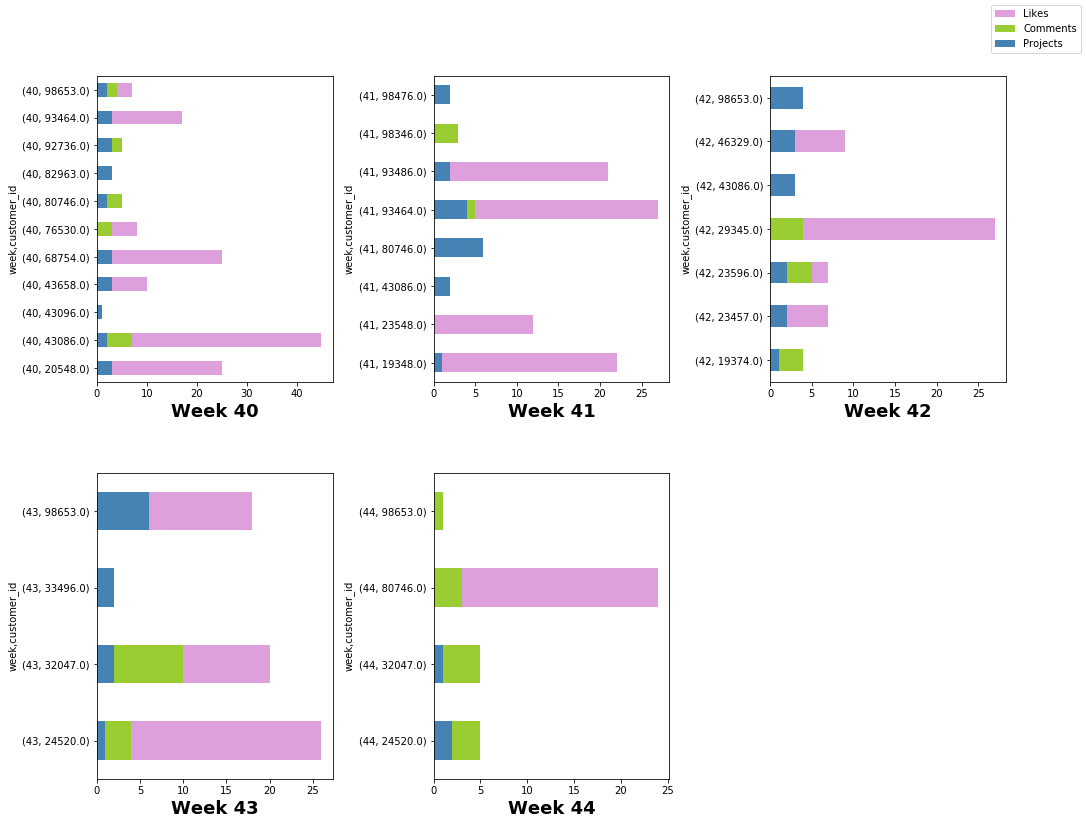

In [84]:
fig=plt.figure(figsize=(15,12))
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)

ax=[ax0,ax1,ax2,ax3,ax4]
fig.tight_layout(pad=7.0)

labels=['Week 40','Week 41','Week 42','Week 43','Week 44']

i=0
for j in range(40,45):
        
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==1]['session_likes_given'].plot(kind='barh',ax=ax[i],color='plum')
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==1]['session_comments_given'].plot(kind='barh',ax=ax[i],color='yellowgreen')        
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==1]['session_projects_added'].plot(kind='barh',ax=ax[i],color='steelblue')
        ax[i].set_xlabel(labels[i],fontweight='bold',fontsize=18)
        i+=1
        
fig.legend(labels=['Likes','Comments','Projects'],loc='upper right')

## Moderately engaged users

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be re

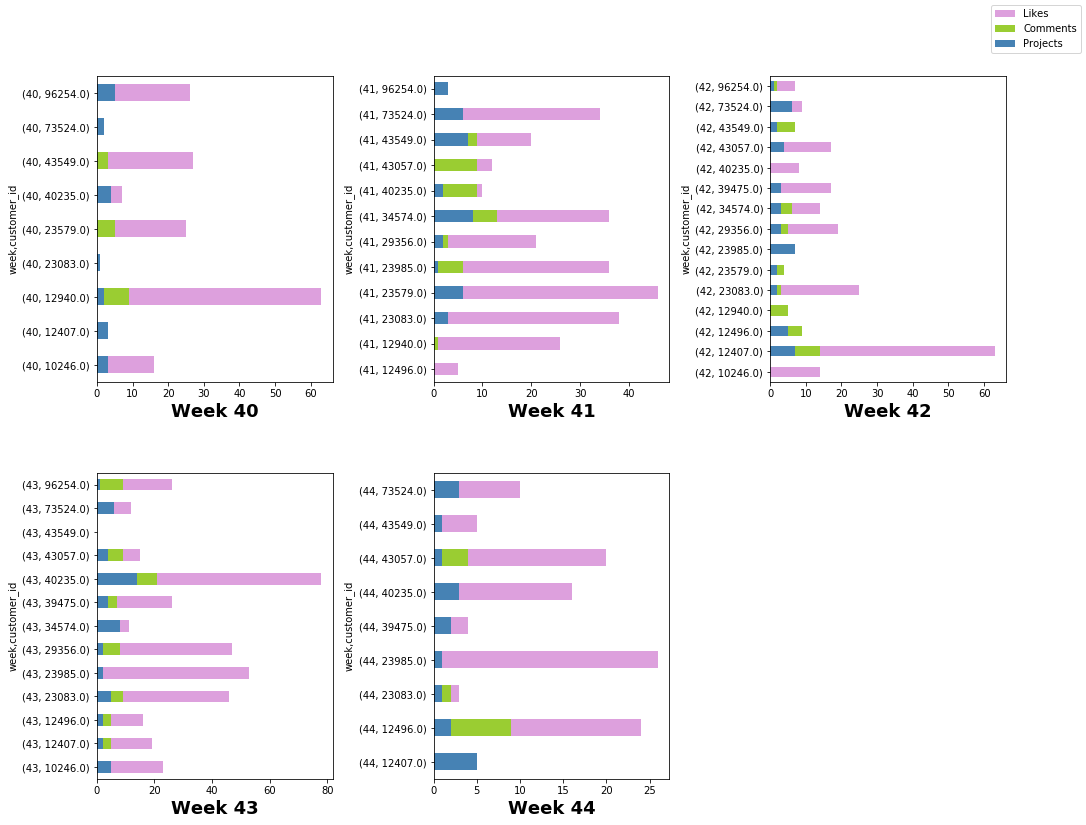

In [83]:
fig=plt.figure(figsize=(15,12))
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)

ax=[ax0,ax1,ax2,ax3,ax4]
fig.tight_layout(pad=7.0)

labels=['Week 40','Week 41','Week 42','Week 43','Week 44']

i=0
for j in range(40,45):
        
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==2]['session_likes_given'].plot(kind='barh',ax=ax[i],color='plum')
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluste1==2]['session_comments_given'].plot(kind='barh',ax=ax[i],color='yellowgreen')
        c2.loc[(c2.index.get_level_values('week') ==j)][c2.cluster==2]['session_projects_added'].plot(kind='barh',ax=ax[i],color='steelblue')
        ax[i].set_xlabel(labels[i],fontweight='bold',fontsize=18)                                                                                                                          
        i+=1
fig.legend(labels=['Likes','Comments','Projects'],loc='upper right')



## Monitoring users overall engagement for each category of users

metirc: Last 30 days (L30)

Text(0, 0.5, 'Count')

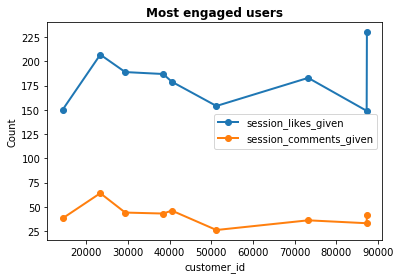

In [129]:
customer[customer.Cluster==0][['session_likes_given','session_comments_given']].plot(marker='o',linewidth=2)
plt.title('Most engaged users',fontweight='bold')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

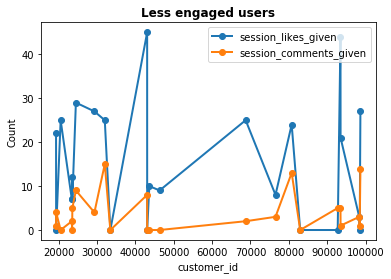

In [124]:
customer[customer.Cluster==1][['session_likes_given','session_comments_given']].plot(marker='o',linewidth=2)
plt.title('Less engaged users',fontweight='bold')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

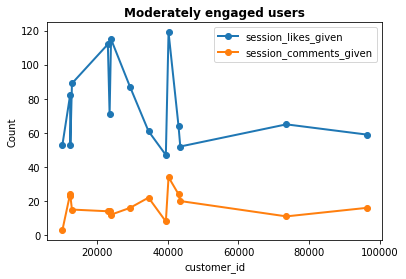

In [125]:
customer[customer.Cluster==2][['session_likes_given','session_comments_given']].plot(marker='o',linewidth=2)
plt.title('Moderately engaged users',fontweight='bold')
plt.ylabel('Count')

## Retention Analytics

## Average Session duration

In [61]:
sd_df = data[['customer_id','login_date','session_duration']].dropna()

In [62]:
sd_df['week'] = sd_df['login_date'].dt.week

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  """Entry point for launching an IPython kernel.


In [63]:
sd_df = pd.DataFrame(sd_df.groupby(['week','customer_id'])['session_duration'].mean())

In [64]:
sd_df = sd_df.rename(columns={'session_duration':'mean_session_duration'})

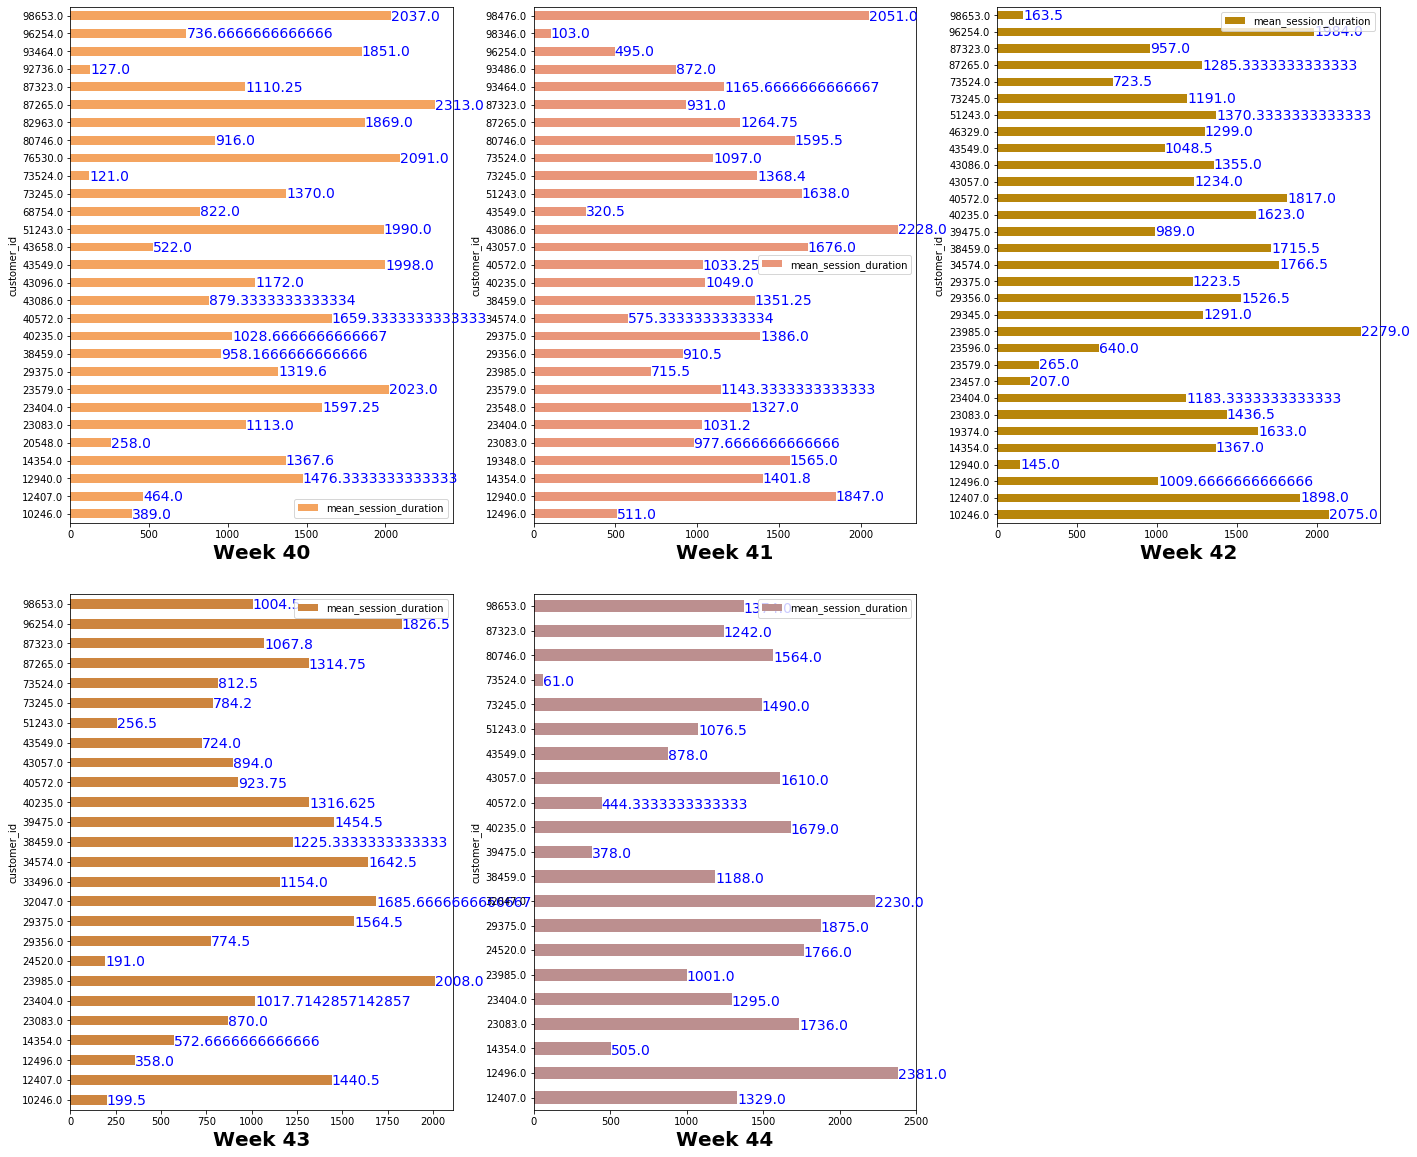

In [82]:
fig=plt.figure(figsize=(20,17))
ax0 = fig.add_subplot(2, 3, 1)
ax1 = fig.add_subplot(2, 3, 2)
ax2 = fig.add_subplot(2, 3, 3)
ax3 = fig.add_subplot(2, 3, 4)
ax4 = fig.add_subplot(2, 3, 5)

ax=[ax0,ax1,ax2,ax3,ax4]
fig.tight_layout(pad=5.0)
col=['sandybrown','darksalmon','darkgoldenrod','peru','rosybrown']
labels=['Week 40','Week 41','Week 42','Week 43','Week 44']

i=0
for j in range(40,45):
        sd_df.loc[j].plot(kind='barh',ax=ax[i],color=col[i])
        
        for idx, v in enumerate(sd_df.loc[j].mean_session_duration):
            ax[i].text(v+0.1 , idx-0.25 , str(v), color='blue',fontsize=14)
        
        ax[i].set_xlabel(labels[i],fontweight='bold',fontsize=20)
        i+=1

## Session Frequency

In [174]:
cluster_df = pd.DataFrame(data.groupby('customer_id')['session_duration'].mean())

In [175]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
y = kmeans.fit_predict(cluster_df[['session_duration']])
cluster_df['cluster'] = y

In [176]:
weekly_df = data[['customer_id','login_date','session_duration']].dropna()
weekly_df['week'] = weekly_df['login_date'].dt.week

/Users/shreysharma/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [177]:
c=[]
for i in range(len(weekly_df)):
    for j in range(len(cluster_df)):
        if  weekly_df.customer_id.values[i]== cluster_df.index.values[j]:
            c.append(cluster_df.cluster.values[j])
weekly_df['cluster']=c

In [178]:
weekly_df = pd.DataFrame(weekly_df.groupby(['cluster','customer_id','week'])['session_duration'].mean())

In [179]:
weekly_df = weekly_df.rename(columns={'session_duration':'mean_session_duration'})

In [189]:
weekly_df.loc[2]

mean_session_duration
customer_id week                       
10246.0     40                    389.0
            42                   2075.0
            43                    199.5
20548.0     40                    258.0
23457.0     42                    207.0
23596.0     42                    640.0
43658.0     40                    522.0
73524.0     40                    121.0
            41                   1097.0
            42                    723.5
            43                    812.5
            44                     61.0
92736.0     40                    127.0
98346.0     41                    103.0

In [183]:
res0= pd.Series([weekly_df.loc[0]['mean_session_duration'].values[i+1] - weekly_df.loc[0]['mean_session_duration'].values[i] 
      for i in range(len(weekly_df.loc[0])-1)])
    

In [184]:
res1= pd.Series([weekly_df.loc[1]['mean_session_duration'].values[i+1] - weekly_df.loc[1]['mean_session_duration'].values[i] 
      for i in range(len(weekly_df.loc[1])-1)])
    

In [185]:
res2= pd.Series([weekly_df.loc[2]['mean_session_duration'].values[i+1] - weekly_df.loc[2]['mean_session_duration'].values[i] 
      for i in range(len(weekly_df.loc[2])-1)])
    

Text(108.125, 0.5, 'Change in mean session duration')

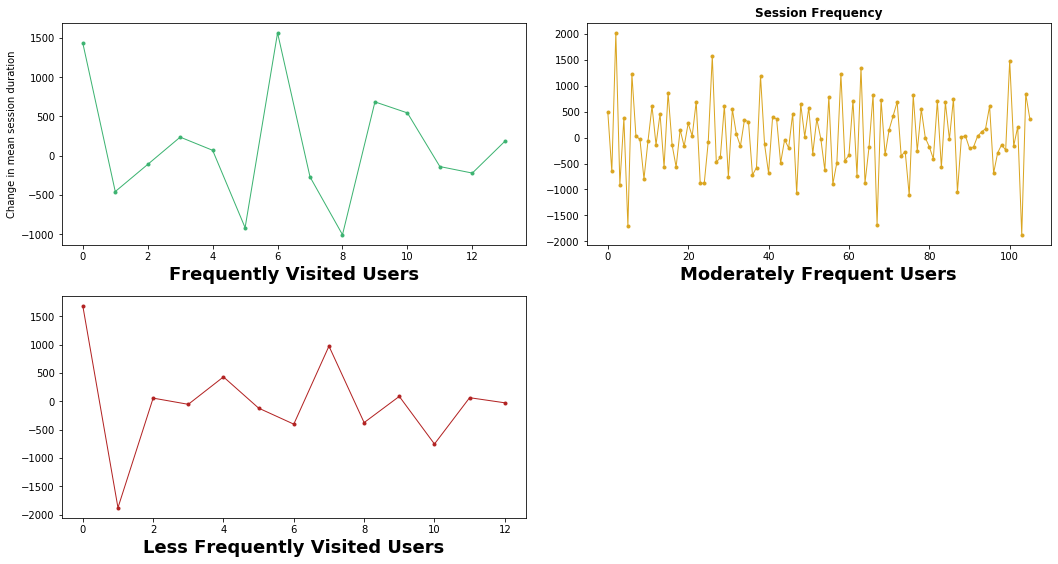

In [193]:
fig=plt.figure(figsize=(15,8))
ax0 = fig.add_subplot(2, 2, 1)
ax1 = fig.add_subplot(2, 2, 2)
ax2 = fig.add_subplot(2, 2, 3)
fig.tight_layout(pad=3.0)

ax1.set_title('Session Frequency',fontweight='bold')

res0.plot(kind='line',marker='.',linewidth=1.0,ax=ax0,color='mediumseagreen')
res1.plot(kind='line',marker='.',linewidth=1.0,ax=ax1,color='goldenrod')
res2.plot(kind='line',marker='.',linewidth=1.0,ax=ax2,color='firebrick')  

ax0.set_xlabel('Frequently Visited Users',fontweight='bold',fontsize=18)
ax1.set_xlabel('Moderately Frequent Users',fontweight='bold',fontsize=18)
ax2.set_xlabel('Less Frequently Visited Users',fontweight='bold',fontsize=18)

ax0.set_ylabel('Change in mean session duration')

### Retention rate

In [191]:
weekly_df.loc[0]

mean_session_duration
customer_id week                       
12407.0     40               464.000000
            42              1898.000000
            43              1440.500000
            44              1329.000000
19348.0     41              1565.000000
19374.0     42              1633.000000
23985.0     41               715.500000
            42              2279.000000
            43              2008.000000
            44              1001.000000
32047.0     43              1685.666667
            44              2230.000000
76530.0     40              2091.000000
82963.0     40              1869.000000
98476.0     41              2051.000000

In [457]:
retention_rate = 8/48 *100
print('Retention Rate: %.3f' % retention_rate)

Retention Rate: 16.667


##  Daily active users (DAU)

In [297]:
df1 = data[['customer_id','login_date','projects_added','likes_given','comment_given']].loc[
    (data['projects_added'] == 1) & (data['likes_given']==1) & (data['comment_given']==1)]

In [298]:
df1 = df1.groupby('customer_id')[['projects_added','likes_given','comment_given']].mean()

In [333]:
df1

,projects_added,likes_given,comment_given
customer_id,,,
10246.0,1,1,1
12407.0,1,1,1
12496.0,1,1,1
12940.0,1,1,1
14354.0,1,1,1
19348.0,1,1,1
23083.0,1,1,1
23404.0,1,1,1
23457.0,1,1,1


In [300]:
len(df1)

33